<a href="https://colab.research.google.com/github/codewithpradeep14/Minor_course_projects_and_labs/blob/main/Module_9_project_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Module 9(b): Convolutional Neural Networks Project

Task 1: Explore the dataset

In [ ]:
# We have imported the necessary packages here. Feel free to import anything more you need!
import torch
import torchvision
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dlib
import cv2
from PIL import Image

Download and load dataset

In [ ]:
!gdown https://drive.google.com/uc?id=1YrNrok2Z1udWWIpejXIdLk7duUq87s0N
!unzip fer2013.csv.zip

Downloading...
From (original): https://drive.google.com/uc?id=1YrNrok2Z1udWWIpejXIdLk7duUq87s0N
From (redirected): https://drive.google.com/uc?id=1YrNrok2Z1udWWIpejXIdLk7duUq87s0N&confirm=t&uuid=c893847c-3500-4035-bae8-d3699770c367
To: /content/fer2013.csv.zip
100% 101M/101M [00:01<00:00, 85.9MB/s] 
Archive:  fer2013.csv.zip
  inflating: fer2013.csv             


In [ ]:
# Load the dataset csv using pandas package. It displays the data in tabular form
emotion_data = pd.read_csv('./fer2013.csv')
print(emotion_data)

FileNotFoundError: [Errno 2] No such file or directory: './fer2013.csv'

In [ ]:
# Class dictionary for dataset
classes = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

Visualize a few images from dataset

In [ ]:
fig = plt.figure(figsize=(12,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  # This is how we access ith row in 'pixels' column in the dataset table
  img = emotion_data.iloc[i]['pixels'].split(' ') # Converting into array of ints
  img = np.array(img).astype(int)

  # Labels for our dataset
  label = int(emotion_data.iloc[i]['emotion'])
  ax.imshow(img.reshape((48,48)), cmap='gray')
  ax.set_title(classes[label])
  ax.set_axis_off()
plt.show()

In [ ]:
names, counts = np.unique(emotion_data['Usage'].to_numpy(), return_counts=True)
print('Number of samples in {} = {}'.format(names[0], counts[0])) #testset
print('Number of samples in {} = {}'.format(names[1], counts[1])) #valset
print('Number of samples in {} = {}'.format(names[2], counts[2])) #trainset

Distribution of class labels

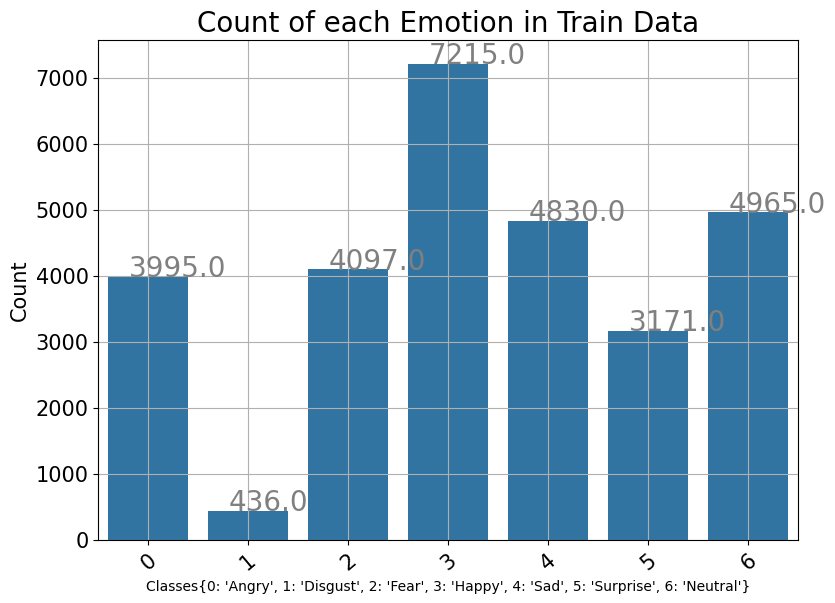

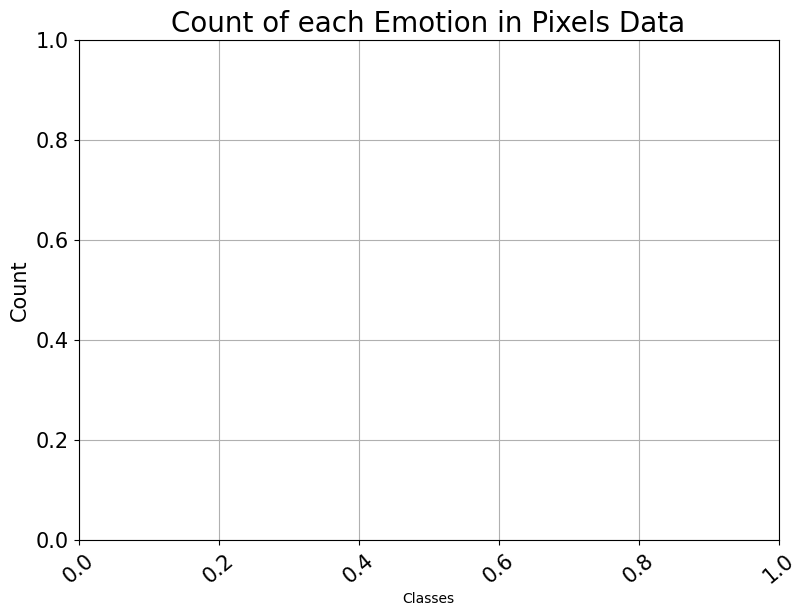

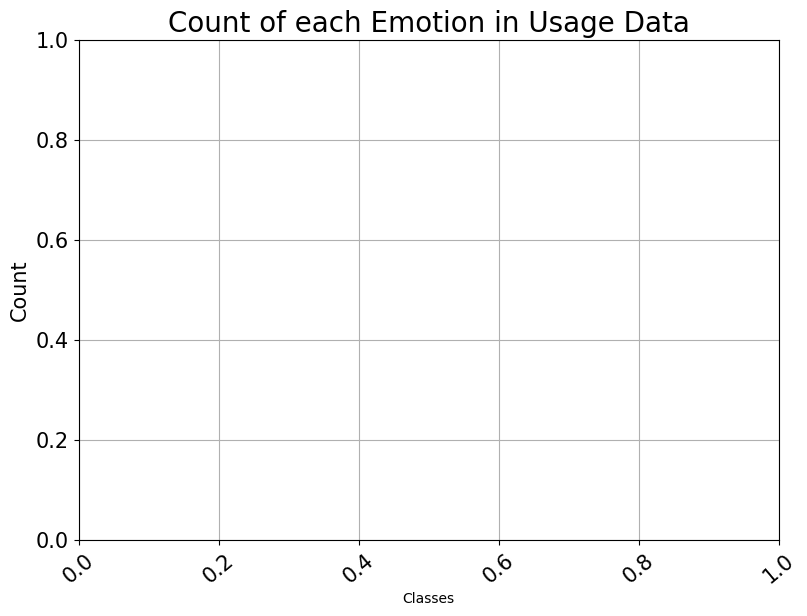

In [ ]:
# Plot bar chart showing number of samples per class in the train set
temp_train = emotion_data.loc[emotion_data['Usage'] == 'Training']
df_temp_train = temp_train.sort_values(by = "emotion", inplace = False)
fig = plt.figure(figsize = (7, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Count of each Emotion in Train Data", fontsize = 20)
sns.countplot(x = "emotion", data = df_temp_train)
plt.grid()
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height()+1.5, s = str(i.get_height()), fontsize = 20, color = "grey")
plt.xlabel("Classes"+ str(classes))
plt.ylabel("Count", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 40)
plt.show()

# Plot bar chart showing number of samples per class in the Pixels set
temp_pixels = emotion_data.loc[emotion_data['Usage'] == 'Pixels']
df_temp_pixels = temp_pixels.sort_values(by="emotion", inplace=False)
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title("Count of each Emotion in Pixels Data", fontsize=20)
sns.countplot(x="emotion", data=df_temp_pixels)
plt.grid()
for i in ax.patches:
    ax.text(x=i.get_x() + 0.2, y=i.get_height() + 1.5, s=str(i.get_height()), fontsize=20, color="grey")
plt.xlabel("Classes")
plt.ylabel("Count", fontsize=15)
plt.tick_params(labelsize=15)
plt.xticks(rotation=40)
plt.show()

# Plot bar chart showing number of samples per class in the Usage set
temp_usage = emotion_data.loc[emotion_data['Usage'] == 'Usage']
df_temp_usage = temp_usage.sort_values(by="emotion", inplace=False)
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title("Count of each Emotion in Usage Data", fontsize=20)
sns.countplot(x="emotion", data=df_temp_usage)
plt.grid()
for i in ax.patches:
    ax.text(x=i.get_x() + 0.2, y=i.get_height() + 1.5, s=str(i.get_height()), fontsize=20, color="grey")
plt.xlabel("Classes")
plt.ylabel("Count", fontsize=15)
plt.tick_params(labelsize=15)
plt.xticks(rotation=40)
plt.show()



Task 2: Data preprocessing

Creating train, validation and test sets

In [ ]:
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

for index, row in emotion_data.iterrows():
    k = row['pixels'].split(" ")

    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'Validation':
        X_val.append(np.array(k))
        y_val.append(row['emotion'])
    elif row['Usage'] == 'Testing':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape: ', X_train.shape, y_train.shape)
print('Validation set shape: ', X_val.shape, y_val.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)


Training set shape:  (28709, 2304) (28709,)
Validation set shape:  (0,) (0,)
Testing set shape:  (0,) (0,)


In [ ]:
# To get data between 0 and 1
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.
X_val = X_val.astype(float) / 255.

In [ ]:
class Fer2013Dataset(Dataset):
  def __init__(self, x, y, transforms=None):
    self.x = x.reshape((-1, 48, 48))
    self.y = y
    self.transforms= transforms

  def __getitem__(self, index):
    img, y = self.x[index], self.y[index]

    if self.transforms is not None:
        img = self.transforms(img)
    return img, y

  def __len__(self):
    return len(self.y)

In [ ]:
batch_size=32

transform = transforms.ToTensor()

# Create tensor dataset from above tensors
train_dataset = Fer2013Dataset(X_train, y_train, transforms=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)

val_dataset = Fer2013Dataset(X_val, y_val, transforms=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

test_dataset = Fer2013Dataset(X_test, y_test, transforms=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

Task 3: Building a CNN model

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(256 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 7)  # Assuming 7 classes for emotions

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(-1, 256 * 6 * 6)  # Flatten

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)

        return x


In [ ]:
# Device (CPU/GPU)
device = 'cpu' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the CNN
model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=7, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


Training/Testing functions

In [ ]:
def train(model, train_loader, loss_func, optimizer, num_epochs):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):

      # clear gradients for this training step
      optimizer.zero_grad()

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients
      loss.backward()

      # Apply gradients
      optimizer.step()

      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [ ]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

Task 4: Training & Evaluation


Train the model

In [ ]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer with learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)


history = train(model, train_loader, criterion, optimizer, num_epochs=1)

ValueError: optimizer got an empty parameter list